In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")

In [2]:
STATE = 2023
TEMPLATE = "ggplot2"
N_CLUST = 3
N_SAMPLES = 100
STD = 1.0

In [3]:
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
import pandas as pd
import torch
from sklearn.datasets import make_blobs


pio.templates.default = TEMPLATE

PALETTE = px.colors.qualitative.Plotly
MARKER = dict(color="black", size=14)

figKwargs = dict(
    width=600,
    height=500,
    color_discrete_sequence=PALETTE,
)
showKwargs = dict(
    renderer="png", scale=2
)  # change renderer to "" to use interactive plots

In [4]:
X_np, y = make_blobs(N_SAMPLES, cluster_std=STD, random_state=STATE, centers=N_CLUST)
X = torch.from_numpy(X_np)
data = pd.DataFrame(X_np, columns=["x", "y"])
data["label"] = y.astype("str")
data.head()

,x,y,label
0,1.183732,-8.288026,1
1,1.092865,-7.411113,1
2,-5.746528,0.425609,2
3,0.305555,-8.296799,1
4,-7.085940,-2.835521,2


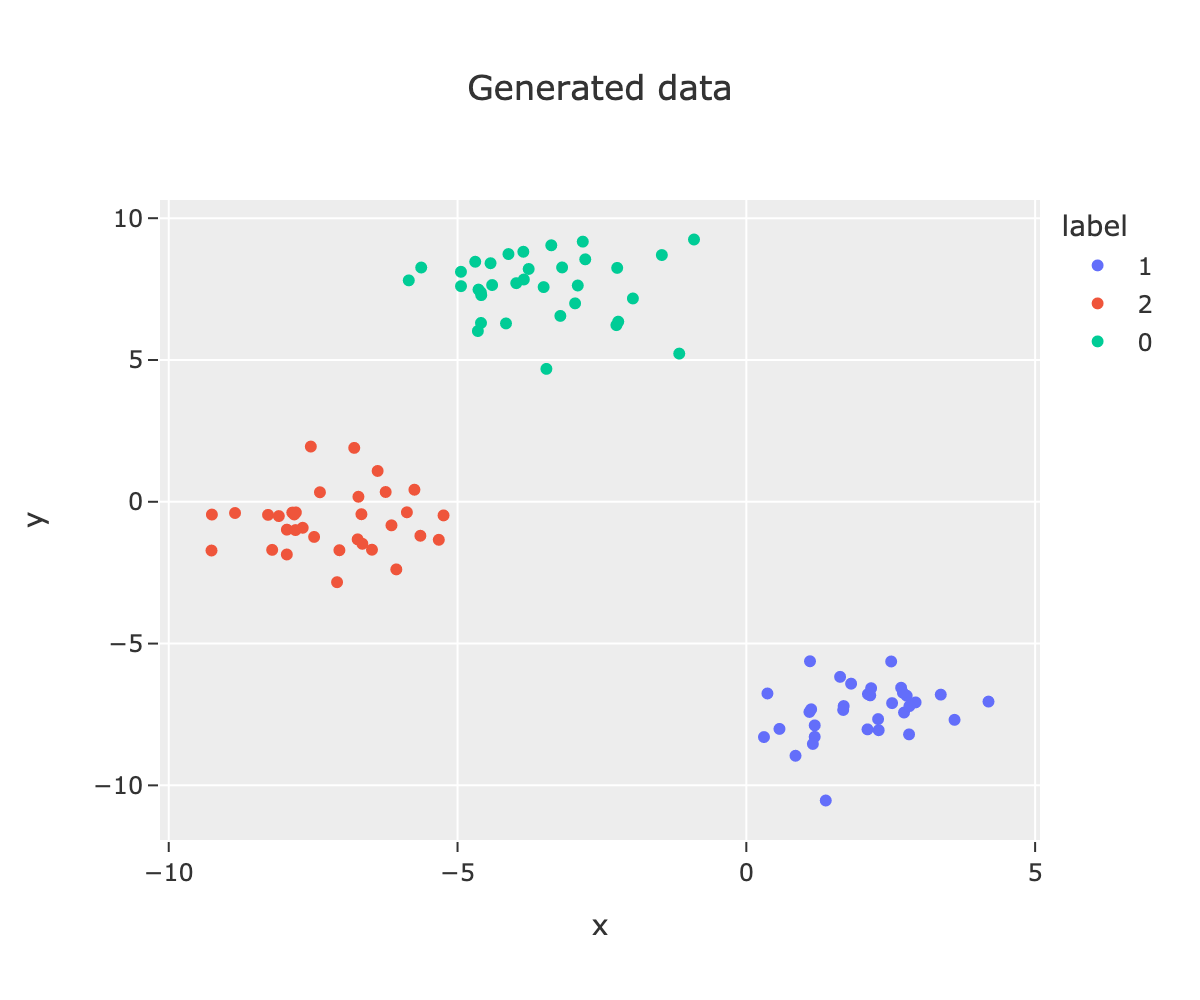

In [5]:
fig = px.scatter(data, x="x", y="y", color="label", title="Generated data", **figKwargs)
fig.show(**showKwargs)

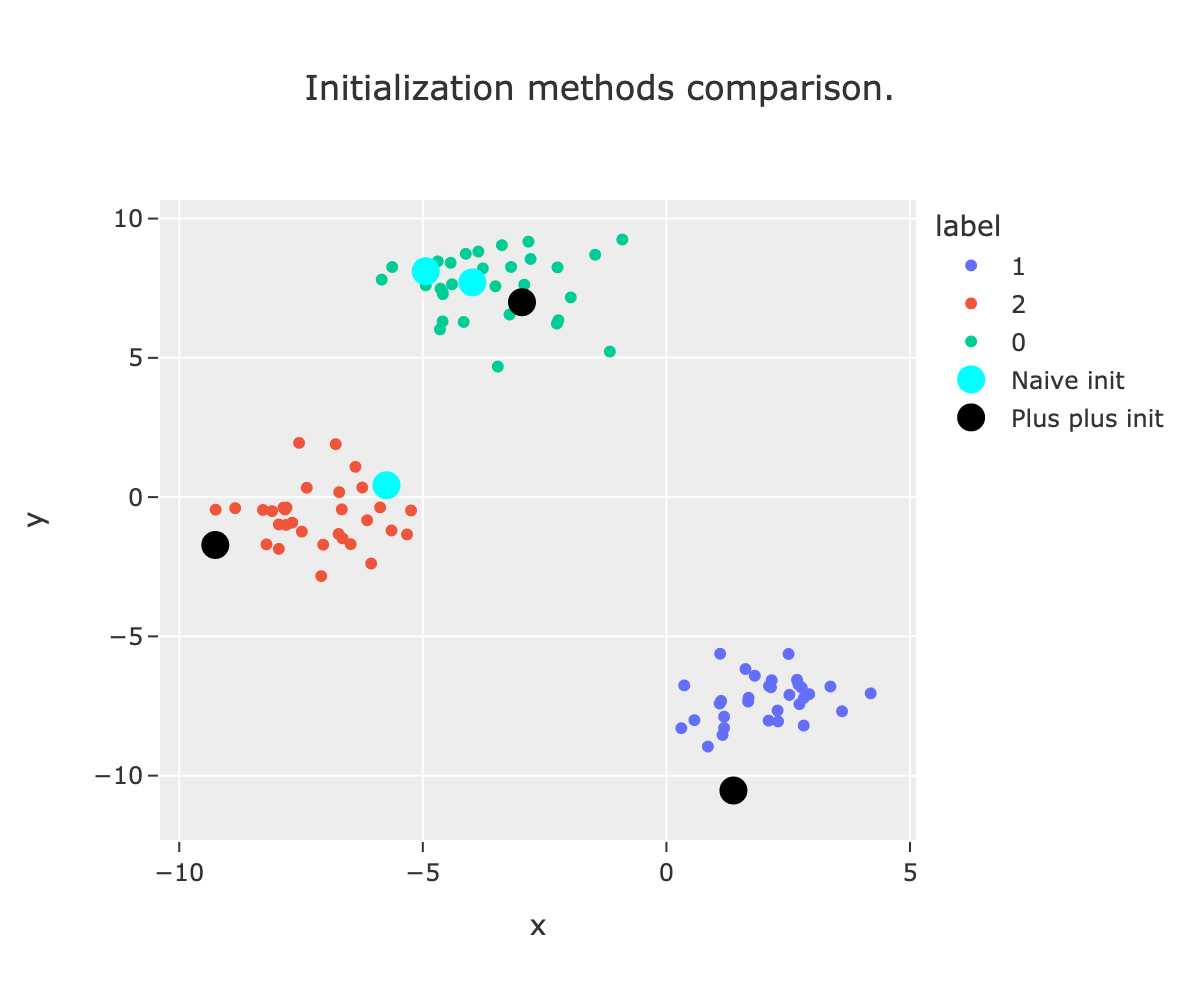

In [6]:
from ml.models.cluster.functional import init_centroids, plus_plus_init_centroids
from ml.distance.functional import eucledian_dist, eucledian_dist_loops


naive_kwargs = {"marker": {"size": 14, "color": "cyan"}, "name": "Naive init"}
plus_plus_kwargs = {"marker": {"size": 14, "color": "black"}, "name": "Plus plus init"}
generator = torch.manual_seed(STATE)
naive_init = init_centroids(X, N_CLUST, generator)
plus_plus_init = plus_plus_init_centroids(X, N_CLUST, generator)

title = "Initialization methods comparison."
fig = px.scatter(data, x="x", y="y", color="label", title=title, **figKwargs)
fig.add_trace(
    go.Scatter(x=naive_init[:, 0], y=naive_init[:, 1], mode="markers", **naive_kwargs)
)
fig.add_trace(
    go.Scatter(
        x=plus_plus_init[:, 0],
        y=plus_plus_init[:, 1],
        mode="markers",
        **plus_plus_kwargs
    )
)
fig.show(**showKwargs)

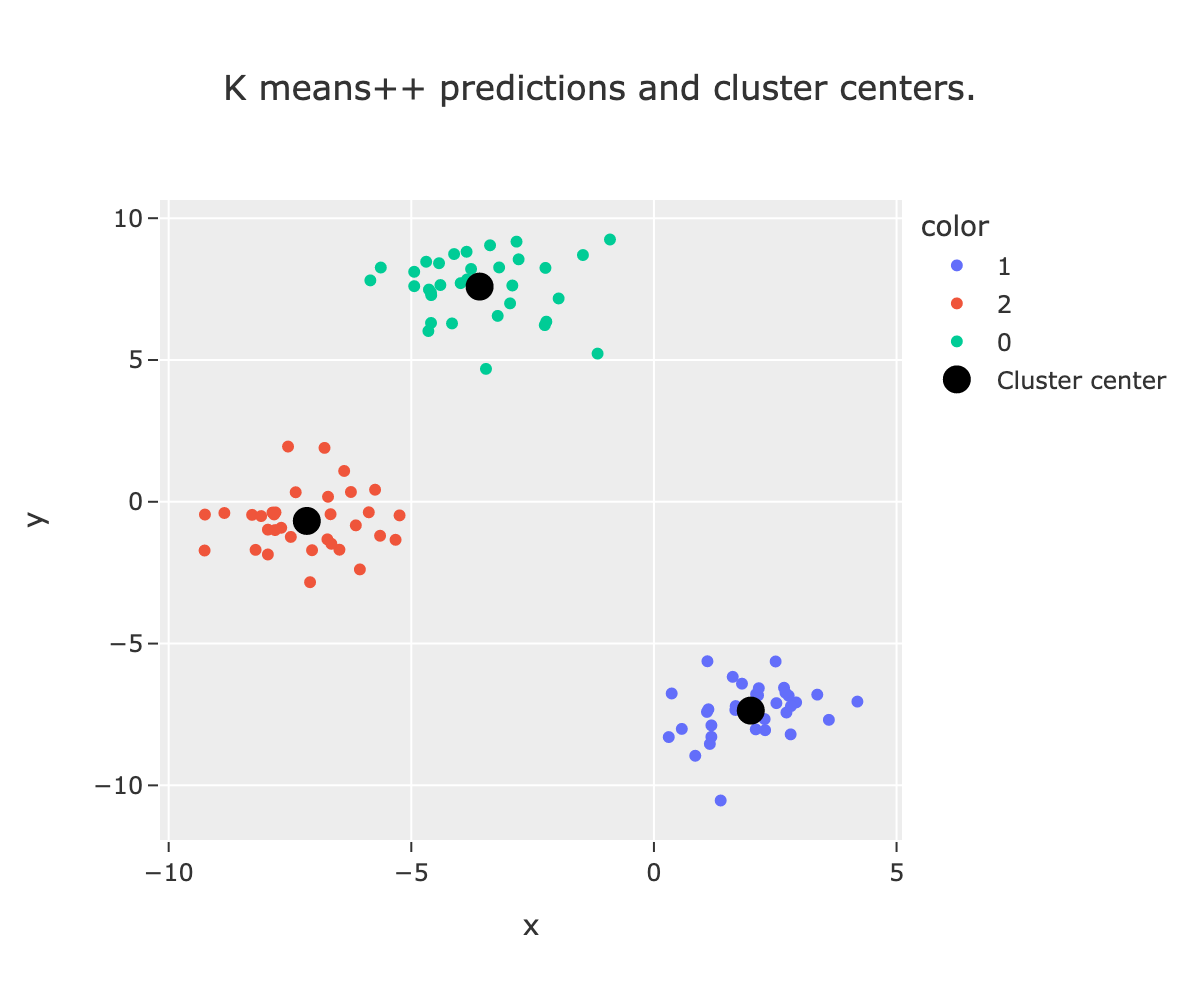

In [7]:
from ml.models.cluster import KMeans

clusterer = KMeans(N_CLUST, random_state=STATE)
clusterer.fit(X)
labels = clusterer.predict(X).numpy()

title = "K means++ predictions and cluster centers."
fig = px.scatter(data, x="x", y="y", color=labels.astype(str), title=title, **figKwargs)
fig.add_trace(
    go.Scatter(
        x=clusterer.centroids[:, 0],
        y=clusterer.centroids[:, 1],
        mode="markers",
        name="Cluster center",
        marker=MARKER,
    )
)
fig.show(**showKwargs)

### Animation

In [8]:
import pandas as pd
import numpy as np

from ml.models.cluster.functional import (
    find_closest_centroid,
    _k_means,
    init_centroids,
    plus_plus_init_centroids,
)

# init_fn = plus_plus_init_centroids
init_fn = init_centroids
max_iter = 10

In [9]:
all_centroids = [init_fn(X, N_CLUST, torch.manual_seed(STATE))]
iters = [torch.zeros(all_centroids[-1].shape[0], 1)]
dists = eucledian_dist(X, all_centroids[-1])
labels = find_closest_centroid(dists)
dfs = []

for i in range(max_iter - 1):
    cur_df = data.copy()
    cur_df["iter"] = float(i)
    cur_df["size"] = 1
    cur_df["label"] = labels.numpy().astype(str)
    dfs.append(cur_df)
    all_centroids.append(_k_means(X, all_centroids[-1]))
    iters.append(iters[-1] + 1)
    dists = eucledian_dist(X, all_centroids[-1])
    labels = find_closest_centroid(dists)

cur_df = data.copy()
dists = eucledian_dist(X, all_centroids[-1])
labels = find_closest_centroid(dists)
cur_df = data.copy()
cur_df["iter"] = float(i + 1)
cur_df["size"] = 1
cur_df["label"] = labels.numpy().astype(str)
dfs.append(cur_df)
dfs = pd.concat(dfs)


iters = torch.stack(iters)
all_centroids = torch.stack(all_centroids)
centers = torch.dstack([all_centroids, iters])


centers = centers.view(max_iter * all_centroids.shape[1], 3).numpy()
centers = pd.DataFrame(centers, columns=["x", "y", "iter"])
centers["size"] = 5
centers["label"] = list(range(0, N_CLUST)) * max_iter
centers["label"] = centers["label"].astype(str)


dfs = pd.concat([dfs, centers])
colormap = {k: PALETTE[int(k)] for k in dfs["label"]}
dfs.head()

,x,y,label,iter,size
0,1.183732,-8.288026,2,0.0,1
1,1.092865,-7.411113,2,0.0,1
2,-5.746528,0.425609,2,0.0,1
3,0.305555,-8.296799,2,0.0,1
4,-7.085940,-2.835521,2,0.0,1


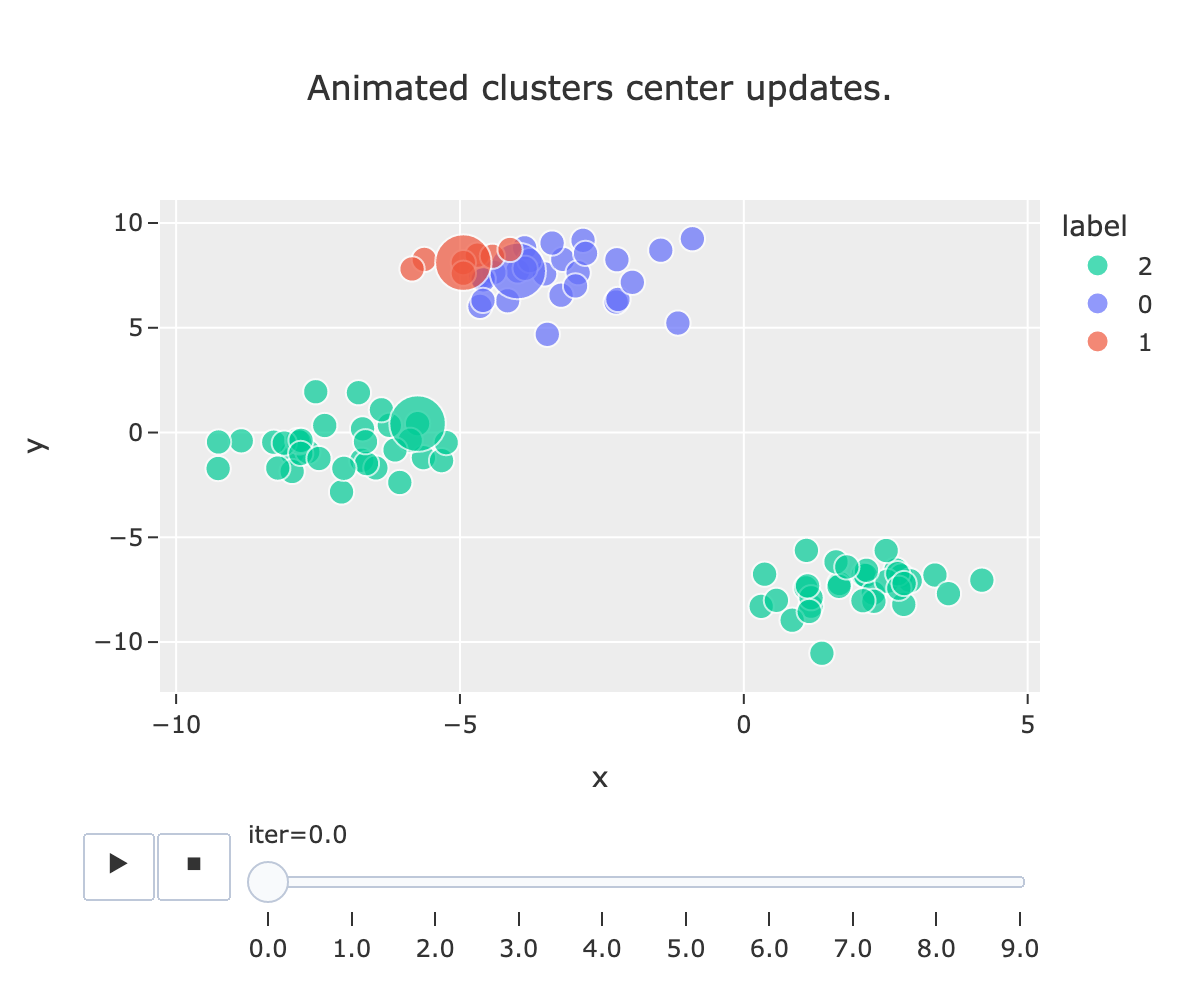

In [10]:
title = "Animated clusters center updates."
fig = px.scatter(
    dfs,
    x="x",
    y="y",
    animation_frame="iter",
    size="size",
    color="label",
    color_discrete_map=colormap,
    title=title,
    **figKwargs
)
fig.show(**showKwargs)